In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import networkx as nx
from time import time
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
from sklearn.linear_model import LinearRegression

from genet.estimators import GenElasticNetEstimator


# ----------------------- Utilities -----------------------

import numpy as np
import networkx as nx

import numpy as np
import networkx as nx
from itertools import product

def grid_graph_incidence(shape):
    """
    Build an axis-aligned lattice graph for a given shape (2D: (H, W), 3D: (A, B, C))
    and return:
      - D: edge-by-node oriented incidence matrix (m, p) with columns ordered in C-order
      - ravel: tensor -> vector in that same C-order
      - unravel: vector -> tensor with given shape
      - coords: list of node coordinate tuples in column order of D
    """
    # Normalize shape and build explicit coordinate ranges
    shape = tuple(int(s) for s in shape)
    assert 2 <= len(shape) <= 3, "shape must be 2D or 3D"

    ranges = [range(s) for s in shape]
    # In itertools.product(*ranges), the rightmost range varies fastest
    # This matches NumPy's C-order flattening.
    coords = list(product(*ranges))  # e.g., (i, j) or (i, j, k)

    # Build the lattice graph; keep tuple labels (no relabeling)
    try:
        G = nx.grid_graph(dim=ranges)   # works on many versions
    except TypeError:
        G = nx.grid_graph(ranges)       # fallback signature

    # By default, incidence_matrix returns (n_nodes, n_edges) — we transpose to (m, p)
    D = nx.incidence_matrix(G, oriented=True)
    D = D.T.astype(float).toarray()     # shape (m, p), edge-by-node

    # Ravel / unravel consistent with coords order (C-order)
    def ravel(tensor_beta):
        return np.asarray(tensor_beta, dtype=float).reshape(-1, order="C")

    def unravel(vec_beta):
        return np.asarray(vec_beta, dtype=float).reshape(shape, order="C")

    return D, ravel, unravel, coords




def beta_true_2d(shape, levels=(1.0, -0.8)):
    """Piecewise-smooth 2D beta (two rectangular blobs with smooth edges)."""
    H, W = shape
    B = np.zeros((H, W))
    B[H//8: 3*H//8, W//6: W//3] = levels[0]
    B[H//2: 7*H//8, 2*W//3: 5*W//6] = levels[1]
    # optional light smoothing (Gaussian-like via averaging)
    for _ in range(3):
        B = 0.25*(np.pad(B, 1, mode='edge')[2:,1:-1] + np.pad(B, 1, mode='edge')[:-2,1:-1] +
                  np.pad(B, 1, mode='edge')[1:-1,2:] + np.pad(B, 1, mode='edge')[1:-1,:-2])
    return B


def beta_true_3d(shape, level=1.0):
    """A single cuboid block inside a 3D grid."""
    A, B, C = shape
    V = np.zeros((A, B, C))
    V[A//4: A//2, B//4: 3*B//5, C//3: 2*C//3] = level
    return V


def fit_rmse_grid(X, y, Xte, yte, D, L1_GRID, L2_GRID, solver="admm"):
    """
    Sweep (l1,l2) and return:
       rmse_grid: [len(L1) x len(L2)]
       best: dict with l1,l2,rmse,beta_hat
    """
    rmse_grid = np.empty((len(L1_GRID), len(L2_GRID)))
    best = {"rmse": np.inf, "l1": None, "l2": None, "beta": None}

    for i, l1 in enumerate(L1_GRID):
        for j, l2 in enumerate(L2_GRID):
            est = GenElasticNetEstimator(l1=l1, l2=l2, D=D, family="normal", solver=solver)
            try:
                est.fit(X, y)
                yhat = est.predict(Xte)
                rmse = norm(yte - yhat) / np.sqrt(Xte.shape[0])
                rmse_grid[i, j] = rmse
                if rmse < best["rmse"]:
                    best.update({"rmse": rmse, "l1": l1, "l2": l2, "beta": est.beta.copy()})
            except Exception:
                rmse_grid[i, j] = np.nan

    return rmse_grid, best


def plot_rmse_heatmap(rmse_grid, L1_GRID, L2_GRID, title):
    plt.figure(figsize=(6.6, 5))
    im = plt.imshow(
        rmse_grid, origin="lower", aspect="auto", cmap="viridis",
        extent=[np.log10(L2_GRID[0]), np.log10(L2_GRID[-1]),
                np.log10(L1_GRID[0]), np.log10(L1_GRID[-1])]
    )
    plt.colorbar(im, label="RMSE")
    cs = plt.contour(np.log10(L2_GRID), np.log10(L1_GRID), rmse_grid, colors="w", linewidths=0.7)
    plt.clabel(cs, inline=True, fontsize=8, fmt="%.3f")
    plt.xlabel(r"$\log_{10}\,\lambda_2$")
    plt.ylabel(r"$\log_{10}\,\lambda_1$")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_beta_maps_2d(beta_true_grid, beta_hat_grid, title_prefix="2D"):
    diff = beta_hat_grid - beta_true_grid
    v = np.nanmax(np.abs(np.concatenate([beta_true_grid.ravel(), beta_hat_grid.ravel()])))
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.6))
    im0 = axs[0].imshow(beta_true_grid, cmap="coolwarm", vmin=-v, vmax=v); axs[0].set_title(f"{title_prefix}: β★ (true)")
    im1 = axs[1].imshow(beta_hat_grid, cmap="coolwarm", vmin=-v, vmax=v); axs[1].set_title(f"{title_prefix}: β̂ (est)")
    im2 = axs[2].imshow(diff, cmap="bwr"); axs[2].set_title(f"{title_prefix}: β̂ − β★")
    for ax in axs: ax.axis("off")
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    
# ----------------------- 2D experiment -----------------------

# Grid shape & truth
shape2d = (18, 22)  # H x W
D2, ravel2, unravel2, _ = grid_graph_incidence(shape2d)
B2_true = beta_true_2d(shape2d, levels=(1.0, -0.8))
beta2_true = ravel2(B2_true)

# Synthetic data
rng = np.random.default_rng(123)
n = 300
p2 = beta2_true.size
X2 = rng.standard_normal((n, p2))
y2 = X2 @ beta2_true +  rng.standard_normal(n)
X2_te = rng.standard_normal((n, p2))
y2_te = X2_te @ beta2_true + rng.standard_normal(n)

# OLS baseline
ols2 = LinearRegression().fit(X2, y2)
rmse2_ols = norm(y2_te - ols2.predict(X2_te)) / np.sqrt(n)
print(f"[2D] OLS RMSE: {rmse2_ols:.4f}")

# GEN sweep
L1_GRID_2D = np.logspace(-2, 2, 15)   # 0.01 .. 10
L2_GRID_2D = np.logspace(-3, 0.5, 5) # 0.001 .. ~3.16
t0 = time()
rmse2_grid, best2 = fit_rmse_grid(X2, y2, X2_te, y2_te, D2, L1_GRID_2D, L2_GRID_2D, solver="admm")
print(f"[2D] Best RMSE (ADMM): {best2['rmse']:.4f} at (l1={best2['l1']:.3g}, l2={best2['l2']:.3g}); grid time: {time()-t0:.1f}s")

# Visuals: heatmap + 3D surface + maps
plot_rmse_heatmap(rmse2_grid, L1_GRID_2D, L2_GRID_2D, title=f"2D RMSE grid (OLS={rmse2_ols:.3f})")


t0 = time()
rmse2_grid, best2_cgd = fit_rmse_grid(X2, y2, X2_te, y2_te, D2, L1_GRID_2D, L2_GRID_2D, solver="cgd")
print(f"[2D] Best RMSE (CGD): {best2_cgd['rmse']:.4f} at (l1={best2_cgd['l1']:.3g}, l2={best2_cgd['l2']:.3g}); grid time: {time()-t0:.1f}s")

# Visuals: heatmap + 3D surface + maps
plot_rmse_heatmap(rmse2_grid, L1_GRID_2D, L2_GRID_2D, title=f"2D RMSE grid (OLS={rmse2_ols:.3f})")



t0 = time()
rmse2_grid, best2_cvx = fit_rmse_grid(X2, y2, X2_te, y2_te, D2, L1_GRID_2D, L2_GRID_2D, solver="cvxpy")
print(f"[2D] Best RMSE (CVX): {best2_cvx['rmse']:.4f} at (l1={best2_cvx['l1']:.3g}, l2={best2_cvx['l2']:.3g}); grid time: {time()-t0:.1f}s")

# Visuals: heatmap + 3D surface + maps
plot_rmse_heatmap(rmse2_grid, L1_GRID_2D, L2_GRID_2D, title=f"2D RMSE grid (OLS={rmse2_ols:.3f})")

t0 = time()
rmse2_grid, best2_ip = fit_rmse_grid(X2, y2, X2_te, y2_te, D2, L1_GRID_2D, L2_GRID_2D, solver="ip")
print(f"[2D] Best RMSE (CVX): {best2_ip['rmse']:.4f} at (l1={best2_ip['l1']:.3g}, l2={best2_ip['l2']:.3g}); grid time: {time()-t0:.1f}s")

# Visuals: heatmap + 3D surface + maps
plot_rmse_heatmap(rmse2_grid, L1_GRID_2D, L2_GRID_2D, title=f"2D RMSE grid (OLS={rmse2_ols:.3f})")


[2D] OLS RMSE: 2.7227


KeyboardInterrupt: 

In [2]:
np.logspace(-2, 2, 15) 

array([1.00000000e-02, 1.93069773e-02, 3.72759372e-02, 7.19685673e-02,
       1.38949549e-01, 2.68269580e-01, 5.17947468e-01, 1.00000000e+00,
       1.93069773e+00, 3.72759372e+00, 7.19685673e+00, 1.38949549e+01,
       2.68269580e+01, 5.17947468e+01, 1.00000000e+02])

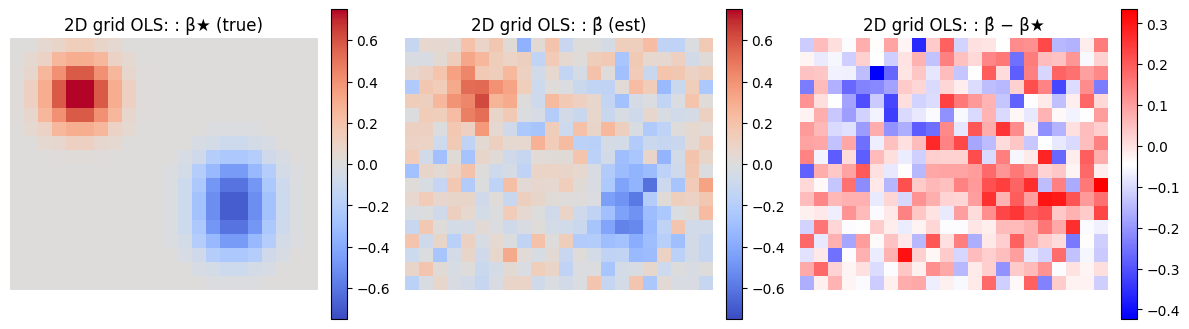

In [ ]:
B2_OLS = unravel2(ols2.coef_)
plot_beta_maps_2d(B2_true, B2_OLS, title_prefix="2D grid OLS: ")

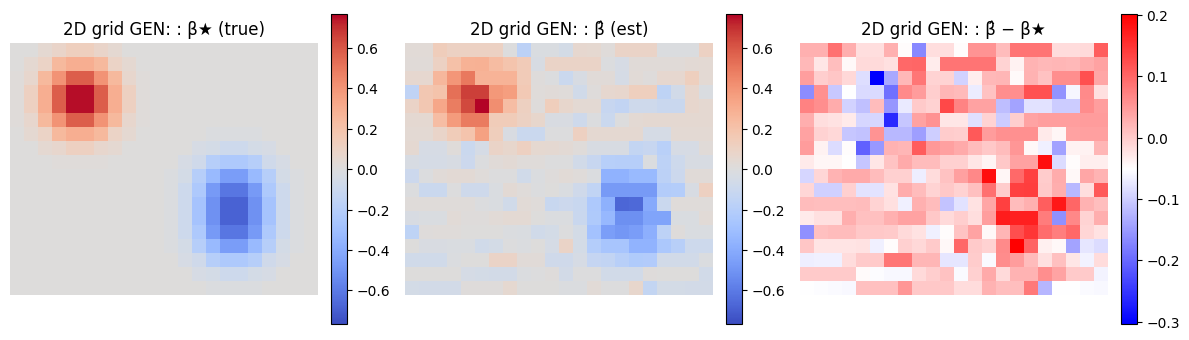

In [ ]:
B2_hat = unravel2(best2["beta"])
plot_beta_maps_2d(B2_true, B2_hat, title_prefix="2D grid GEN (ADMM): ")

In [ ]:
B2_hat = unravel2(best2_cgd["beta"])
plot_beta_maps_2d(B2_true, B2_hat, title_prefix="2D grid GEN (CGD): ")

In [ ]:
B2_hat = unravel2(best2_ip["beta"])
plot_beta_maps_2d(B2_true, B2_hat, title_prefix="2D grid GEN (IP): ")

In [ ]:
B2_hat = unravel2(best2_cvx["beta"])
plot_beta_maps_2d(B2_true, B2_hat, title_prefix="2D grid GEN (CVX): ")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from matplotlib import cm

# Suppose your true coefficient grid is:
# shape2d = (18, 22)
# B2_true = beta_true_2d(shape2d, levels=(1.0, -0.8))

H, W = B2_true.shape
Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# plot_surface takes X, Y, Z arrays of the same shape
surf = ax.plot_surface(Xg, Yg, B2_true, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.9)

ax.set_xlabel("Grid column (j)")
ax.set_ylabel("Grid row (i)")
ax.set_zlabel("Coefficient value β★")
ax.set_title("True coefficient surface (2D grid in 3D)")

fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.1, label="β★ value")
plt.tight_layout()
plt.show()


In [ ]:
# ----------------------- 3D experiment -----------------------

def plot_rmse_3d_surface(rmse_grid, L1_GRID, L2_GRID, title):
    L1m, L2m = np.meshgrid(np.log10(L1_GRID), np.log10(L2_GRID), indexing="ij")
    fig = plt.figure(figsize=(8.2, 6.2))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(L2m, L1m, rmse_grid, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.95)
    ax.set_xlabel(r"$\log_{10}\,\lambda_2$")
    ax.set_ylabel(r"$\log_{10}\,\lambda_1$")
    ax.set_zlabel("RMSE")
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.1, label="RMSE")
    plt.tight_layout()
    plt.show()





def plot_beta_slices_3d(beta_true_vol, beta_hat_vol, title_prefix="3D"):
    """Show central XY, XZ, YZ slices for true & estimated."""
    A, B, C = beta_true_vol.shape
    cx, cy, cz = A//2, B//2, C//2

    def panel(img, ax, ttl):
        im = ax.imshow(img, cmap="coolwarm")
        ax.axis("off"); ax.set_title(ttl); return im

    fig, axs = plt.subplots(2, 3, figsize=(10.5, 6))
    v = np.nanmax(np.abs(np.concatenate([beta_true_vol.ravel(), beta_hat_vol.ravel()])))
    ims = []
    ims += [panel(beta_true_vol[:, :, cz], axs[0,0], "true: XY (z=mid)")]
    ims += [panel(beta_true_vol[:, cy, :], axs[0,1], "true: XZ (y=mid)")]
    ims += [panel(beta_true_vol[cx, :, :].T, axs[0,2], "true: YZ (x=mid)")]
    ims += [panel(beta_hat_vol[:, :, cz], axs[1,0],  "est: XY (z=mid)")]
    ims += [panel(beta_hat_vol[:, cy, :], axs[1,1],  "est: XZ (y=mid)")]
    ims += [panel(beta_hat_vol[cx, :, :].T, axs[1,2], "est: YZ (x=mid)")]
    for im in ims:
        im.set_clim(-v, v)
    fig.suptitle(f"{title_prefix}: central slices", y=0.98, fontsize=13)
    plt.tight_layout()
    plt.show()

